# Mixtures
The goal of this notebook is to examine mixtures of outputs from nucleosynthetic processes.

Begin by installing and importing the necessary python libraries

In [1]:
import sys, io, requests
from ipywidgets import interact, interactive
import ipywidgets as widgets

!{sys.executable} -m pip install --quiet wnutils
!{sys.executable} -m pip install --quiet matplotlib

import matplotlib.pyplot as plt
import wnutils.xml as wx 
import numpy as np
from scipy.optimize import curve_fit

# Preliminaries.

Define a routine to retrieve zone abundances from the xml data.

In [2]:
def get_zone_abunds(my_xml):
    zones = my_xml.get_zone_data()
    proc = {}
    for key in zones:
        proc[key] = {}
        for tup in zones[key]['mass fractions']:
            proc[key][tup[0]] = zones[key]['mass fractions'][tup] / tup[2]
    return proc

Define a routine to retrieve the data for the processes and store in arrays.

In [3]:
def get_proc(sp, norm_species):

    y = []

    proc = {}
    for key in result:
        proc[key] = np.zeros(len(sp))
        count = 0
        for s in sp:
            if s in result[key]:
                proc[key][count] = result[key][s]
            count += 1
            
    for key in result:
        proc[key] /= np.sum(proc[key])
    
    return proc

# Study nucleosynthesis mixtures.

Read in the nucleosynthesis processes data and store in a wnutils XML object.  The default is to use files downloaded from [OSF](https://osf.io/5shf2/).  To use your own data, put them in your working directory or uploading to Colab or Binder.  Then uncomment the second line and replace *example.xml* with the chosen name.

In [4]:
rsp = wx.Xml(io.BytesIO(requests.get('https://osf.io/5ztd7/download').content))
#wx.Xml('example.xml')

Retrieve the data for the processes.

In [5]:
result = get_zone_abunds(rsp)

Specify the species of interest.  Specify the normalizing species and the labelling string.

In [6]:
sp = np.array(['mo92', 'mo94', 'mo95', 'mo96', 'mo97', 'mo98', 'mo100'])
a = np.array([92, 94, 95, 96, 97, 98, 100])
norm_species = 'mo96'
sp_string = '^iMo/^{96}Mo'

Get the process data for the species.  Set the normalization index and mass-fractionation correction species index.  The commented command shows a "hack" to include a small contribution of the p-process to the weak s-process component of mo94.

In [7]:
proc = get_proc(sp, norm_species)
i_norm = np.where(sp == norm_species)

#proc['ws'][1] = 0.05 * proc['p'][1]

Plot the process contributions.

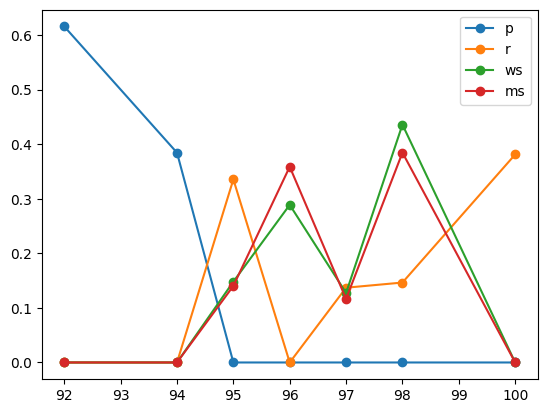

In [8]:
for key in proc:
    plt.plot(a, proc[key], 'o-', label = key)
    
plt.legend()

Input the standard abundance ratios.  Here we use [Anders and Grevesse (1989)](https://osf.io/udvsk/).

In [9]:
solar = wx.Xml(io.BytesIO(requests.get('https://osf.io/w8ktc/download').content))

y = {}
mass_fractions = solar.get_zone_data()['0']['mass fractions']
for tup in mass_fractions:
    y[tup[0]] = mass_fractions[tup] / tup[2]
    
standard = []

for s in sp:
    standard = np.append(standard, y[s] / y[norm_species])

Define a fit function for the processes to the standard abundances.

In [10]:
def fit_function(x, a_p, a_r, a_ms, a_ws):
    result = a_p * proc['p'] + a_r * proc['r'] + a_ms * proc['ms'] + a_ws * proc['ws']
    result /= result[i_norm]
    return result

Compute the best fit to the standard.  Normalize the fit parameters.

In [11]:
popt_std, pcov_std = curve_fit(fit_function, a, standard, bounds=(0, [1, 1, 1, 1]))
popt_std /= np.sum(popt_std)

Plot the fit.

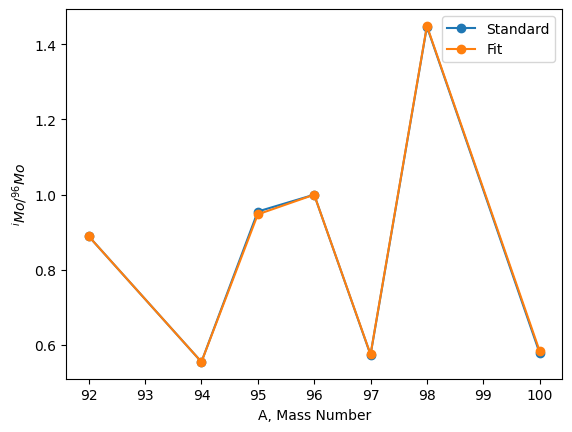

In [12]:
plt.plot(a, standard, '-o', label='Standard')

plt.plot(a, fit_function(a, *popt_std), '-o', label='Fit')

plt.xlabel('A, Mass Number')
plt.ylabel('$' + sp_string + '$')
plt.legend()

Practice adding and subtracting nucleosynthetic components (in parts per million). Set rng to define the range of variation of the components and step to define the increment size. Use the slider bars to adjust the contribution of each component. You can click on a slider and move it, or, once you have clicked on the button, use the left and right arrows on your key board to increase or decrease the contribution. Note that p_proc is the p-process component, r_proc is the r-process component, ms_proc is the main s-process component, and ws_proc is the weak s-process component.

In [13]:
rng = 1000
step = 1

def f(p_proc, r_proc, ms_proc, ws_proc):
    c_p = (1 + p_proc/1.e6) * popt_std[0]
    c_r = (1 + r_proc/1.e6) * popt_std[1]
    c_ms = (1 + ms_proc/1.e6) * popt_std[2]
    c_ws = (1 + ws_proc/1.e6) * popt_std[3]

    standard = fit_function(a, *popt_std)
    standard /= standard[i_norm]
    result = c_p * proc['p'] + c_r * proc['r'] + c_ms * proc['ms'] + c_ws * proc['ws']
    result /= result[i_norm]
    mu = 1.e6 * (result / standard - 1)
        
    plt.plot(a, mu, '-o', label='fit')

    plt.xlabel('A, Mass Number')
    plt.ylabel('$\\mu(' + sp_string + ')$')
        
    plt.show()
        
interact(f, p_proc=(-rng,rng,step), r_proc=(-rng,rng,step), ms_proc=(-rng,rng,step), ws_proc=(-rng,rng,step))

interactive(children=(IntSlider(value=0, description='p_proc', max=1000, min=-1000), IntSlider(value=0, descri…

<function __main__.f(p_proc, r_proc, ms_proc, ws_proc)>

# Compare to data.

Now add data, if desired.  The *data* array shows the deviations from the standard for each species (in parts per million) while *error* is the array giving the uncertainty for each data point.  The *data* and *error* arrays need to match up with the *a* and *sp* arrays defined above except that the mass-fractionation correction species (*correction_species*) is excluded.

To include the data, uncomment the last three lines of the cell, provide your data, and run the following cells.

In [14]:
data = []
error = []

#correction_species = 'mo98'
#data = np.array([-54.1, -26.1, -3.4, 0., 11.3, -40.9])
#error = np.array([34.0, 10.1, 3.9, 0.1, 2.5, 9.5])

Exclude the correction species from the various input arrays.

In [15]:
if len(data) > 0:
    i_corr = np.where(sp == correction_species)

    a_corr = np.delete(a, i_corr)
    sp_corr = np.delete(sp, i_corr)

    proc_corr = {}
    for key in proc:
        proc_corr[key] = np.delete(proc[key], i_corr)

Define a fit function for the anomaly data.

In [16]:
if len(data) > 0:
    def fit_function2(x, a_p, a_r, a_ms, a_ws):
        result = a_p * proc_corr['p'] + a_r * proc_corr['r'] + a_ms * proc_corr['ms'] + a_ws * proc_corr['ws']
        result /= result[i_norm]    
        standard = fit_function(x, *popt_std)
        st_corr = np.delete(standard, i_corr)
        mu = 1.e6 * ((result / st_corr) - 1)
        return mu

Fit the data.  Normalize the fit parameters.

In [17]:
if len(data) > 0:
    popt_mu, pcov_mu = curve_fit(fit_function2, a_corr, data, bounds=(0, [1, 1, 1, 1]), sigma=error)
    popt_mu /= np.sum(popt_mu)

Print the fit parameters.

In [18]:
if len(data) > 0:
    a_fit = 1.e6 * (popt_mu/np.sum(popt_mu)/(popt_std/np.sum(popt_std)) - 1)

    print('p_proc:', a_fit[0])
    print('r_proc:', a_fit[1])
    print('ms_proc:',  a_fit[2])
    print('ws_proc:', a_fit[3])

Add and subtract nucleosynthetic components (in parts per million) to fit the data. Use the slider bars to adjust the contribution of each component. You can click on a slider and move it, or, once you have clicked on the button, use the left and right arrows on your key board to increase or decrease the contributiom. Note that p_proc is the p-process component, r_proc is the r-process component, ms_proc is the main s-process component, and ws_proc is the weak s-process component.

The plot starts with the best fit parameters from the cell above.

In [19]:
if len(data) > 0:
    def f(p_proc, r_proc, ms_proc, ws_proc):
        c_p = (1 + p_proc/1.e6) * popt_std[0]
        c_r = (1 + r_proc/1.e6) * popt_std[1]
        c_ms = (1 + ms_proc/1.e6) * popt_std[2]
        c_ws = (1 + ws_proc/1.e6) * popt_std[3]

        standard = fit_function(a, *popt_std)
        standard /= standard[i_norm]
        st_corr = np.delete(standard, i_corr)
        result = c_p * proc_corr['p'] + c_r * proc_corr['r'] + c_ms * proc_corr['ms'] + c_ws * proc_corr['ws']
        result /= result[i_norm]
        mu = 1.e6 * (result / st_corr - 1)
    
        plt.plot(a_corr, mu, '-o', label='fit')
        plt.errorbar(a_corr, data, fmt='-o', yerr=error, label='data')

        plt.xlabel('A, Mass Number')
        plt.ylabel('$\\mu(' + sp_string + ')$')
        plt.legend()
        
        plt.show()
        
    interact(f, p_proc=a_fit[0], r_proc=a_fit[1], ms_proc=a_fit[2], ws_proc=a_fit[3])